# Lab Three: Extended Logistic Regression

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Preparation and Overview](#prep)<br>
  1.1 [Business Case](#business_case)<br>
  1.2 [Define Class Variables](#class_variables)<br>
  1.3 [Training and Testing Data](#split)<br>
 2. [Modeling](#modeling)<br>
  2.1 [One-Verses-All Logistic Regression](#1vall)<br>
  2.2 [Train the Model](#train)<br>
  2.3 [Compare to Scikit-Learn](#compare)<br>
 3. [Deployment](#deployment)<br>
  3.1 [Advice](#advice)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  4.2 [Mean Square Error](#mse)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="prep"></a>
## Preparation and Overview


<a id="business_case"></a>
### Business Case

>__[20 points]__ Explain the tast and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis?

For this project we will return to the diabetes dataset we used for Lab1. Briefly, this dataset contains information regarding diabetic patients who were admitted to the hospital.

This dataset contains labels that characterize whether the patient was readmitted to the hospital in less than 30 days, readmitted to the hospital after more than 30 days, or not readmitted at all. Predicting these labels will be our classification task. 

There are two potential sets of parties interested in these results. 

- First, emergency medical care centers. These care centers will likely be interested in the results because of the insight they may provide for the day to day operations of the centers. We may discover that certain types of patients are much more likely to be readmitted to an emergency medical care center. This information could be used by the care centers to provide extra attention to the most at-risk patients once identified. In this case, the model would likely be deployed so that the healthcare professionals can have feedback as soon as possible. Throughout this project, we will focus on this possibility so as not to split our time and energy.

- Second, special focus groups, such as the [American Diabetes Association](http://www.diabetes.org/). These organizations can use the insight gained from our studies to issue standards or suggestions. These standards or suggestions could then be implemented at individual care centers. Since the ADA is a large organization with a relative large sphere of influence, these suggestions could help ensure parity accross a variety of care centers. In this case, the model would mostly be used for offline analysis. For this project, we will not focus on this possibility.

<a id="class_variables"></a>
### Define Class Variables

> __[5 points]__ (_mostly the same processes as from previous labs_) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Descrive the final dataset that is used for classificiation/regression (include a description of any newly formed variables you created).

In [31]:
# load the full dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

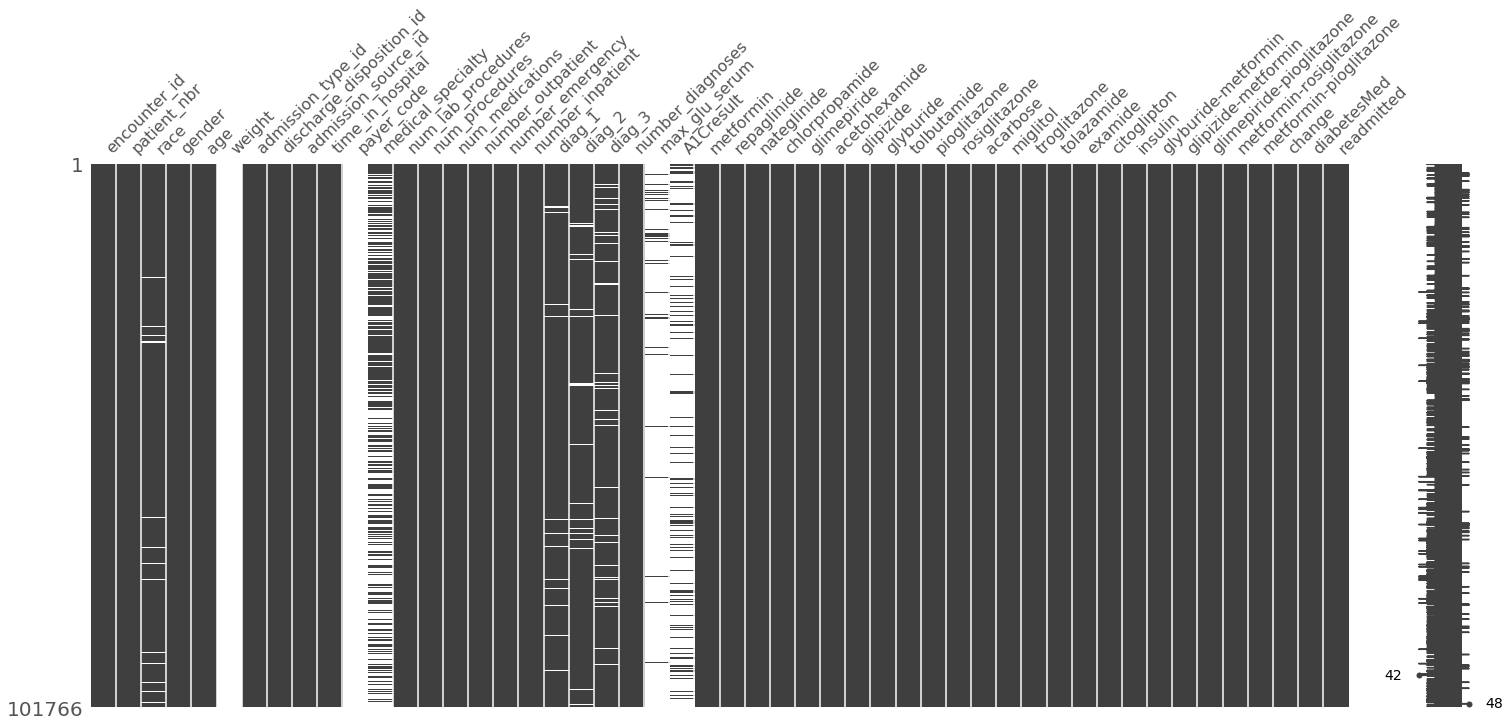

In [32]:
# now convert columns that should be numeric to numeric types,
# then drop the columns missing too mich data and then the rows with any missing data. 

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
    
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code','diag_1','diag_2','diag_3']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

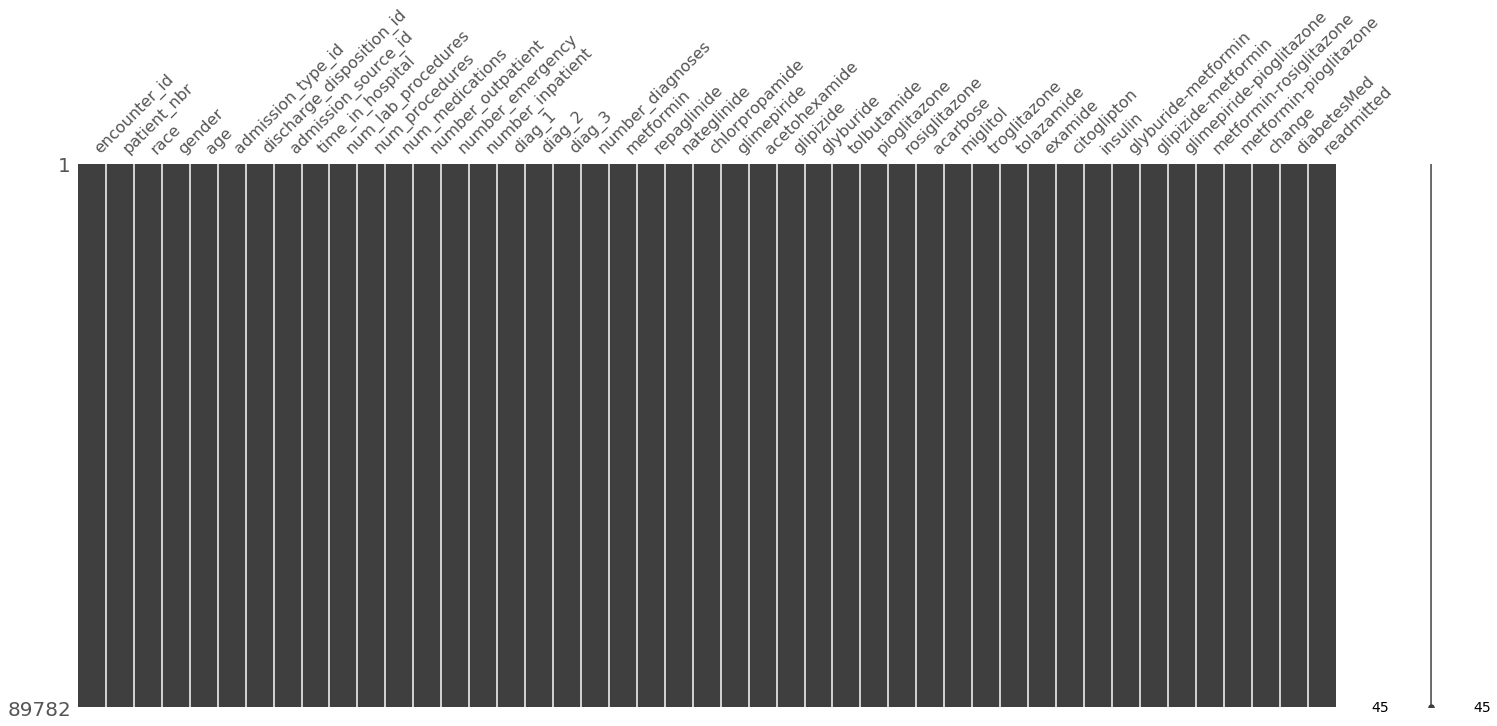

In [33]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
for i in range(len(cols)):
    if datas[i]/size > 0.08:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

In [38]:
full_df['glipizide-metformin'].unique()

array(['No', 'Steady'], dtype=object)

In [42]:
print(full_df.shape)
print(full_df.shape[0]**(1/full_df.shape[1]))
print(1.288459799106489**45)

(89782, 45)
1.288459799106489
89782.00000000015


<a id="split"></a>
### Training and Testing Data

>__[5 points]__ Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. __Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?__

In [ ]:
from sklearn.model_selection import train_test_split

# note, we have not yet split data from target
train, test = train_test_split(full_df, test_size=0.2)

As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. 

<a id="modeling"></a>
## Modeling

> The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

<a id="1vall"></a>
### One-Verses-All Logistic Regression

> __[20 points]__ Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
- Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. 
- Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.

### Train the Model
<a id="train"></a>

> __[15 points]__ Train your classifier to achieve good generalization performance. That is, adjust the __optimization technique__ and the value of the __regularization term "C"__ to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

<a id="compare"></a>
### Compare to Scikit-Learn

> __[15 points]__ Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. __Discuss the results.__

<a id="deployment"></a>
## Deployment


<a id="advice"></a>
### Advice

> __[10 points]__ Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

<a id="exceptional"></a>
## Exceptional Work

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses. __One idea__: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. 

<a id="mse"></a>
### Mean Square Error

> One idea (__required for 7000 level students__): Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one gradient update step. 

<a id="thoughts"></a>
## Final Thoughts

some final thoughts...